In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import acf, pacf, plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.api import tsa
import statsmodels.api as sm
import time
from matplotlib import font_manager as fm, rcParams
import calendar
plt.style.use('ggplot')
plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
plt.rcParams['axes.unicode_minus']=False   #这两行需要手动设置
%matplotlib inline

In [6]:
#读取数据，数据
tmp_df = pd.read_csv('./iml_txn_dpst_fin_dtl_e_casestudy.csv')

tmp_df['date'] = pd.to_datetime(tmp_df['pass_acct_dt'], format='%Y%m%d')
tmp_df = tmp_df.loc[tmp_df['prest_txn_tm']!=0]
tmp_df = tmp_df.loc[tmp_df['txn_amt']>=-50000]
tmp_df.set_index('date', inplace=True)
tmp_df = tmp_df[['prest_txn_tm','txn_amt']]
tmp_df.head()

,prest_txn_tm,txn_amt
date,,
2019-07-13,10514868,150.0
2019-07-13,10320728,50.0
2019-07-13,11202778,50.0
2019-07-13,11202875,225.0
2019-07-13,15475186,80.0


In [7]:
def count_deposit_ratios(df, baseline):
    total = df.loc[df['txn_amt']>0].count()
    count = df.loc[df['txn_amt']>baseline].count()
    percentage = count/total
    print('total:{}, count:{}, percentage:{}'.format(total, count, percentage))
    return percentage

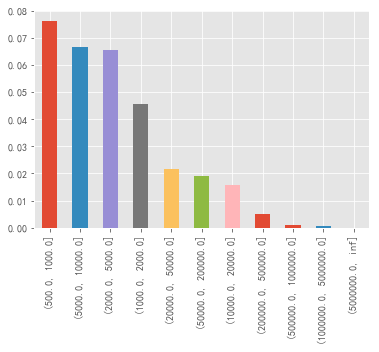

In [8]:
sections = [500,1000,2000,5000,10000,20000,50000,200000,500000,1000000,5000000,np.inf]
(pd.cut(tmp_df['txn_amt'],sections).value_counts()/tmp_df['txn_amt'].shape[0]).plot(kind='bar')

In [9]:
from joblib import Parallel, delayed
def sum_by_date(df):
    return df.groupby('date').sum()

def seq_filter_in(seq, threshold):
    return seq.loc[seq['txn_amt']<=threshold]

def seq_filter_out(seq, threshold):
    return seq.loc[seq['txn_amt']>=threshold]

def drop_trade_threshold(df,threshold):
    df = df.loc[df['txn_amt']<=threshold]
    return df

def get_daily_cash_req(tmp_df):
    tmp_df = tmp_df.sort_values(by=['date','prest_txn_tm'])
    tmp_group = tmp_df.groupby('date')
    tmp_group = tmp_group.cumsum()
    daily_cash_req = tmp_group.groupby('date').min()
    daily_cash_req = daily_cash_req.rename(columns={'txn_amt':'cash_req'})
    return daily_cash_req

def autocorrelation(timeseries, lags):
    import statsmodels.api as sm
    fig = plt.figure(figsize=(12, 8))
    plt.suptitle(timeseries.name, fontsize=20)
    ax1 = fig.add_subplot(211)
    sm.graphics.tsa.plot_acf(timeseries, lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    sm.graphics.tsa.plot_pacf(timeseries, lags=lags, ax=ax2)
    plt.show()
    
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

#定义模型预测
def model_forcast(history, config):
    order, sorder, trend = config
    model = sm.tsa.statespace.SARIMAX(history, order=order, seasonal_order=soder,
                                     enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]
#one_step滚动向前预测
def forward_valid(data, n_test, config):
    predictions = list()
    train, test = train_test_split(data, n_test)
    history = [x for x in train]
    for i in range(len(test)):
        yhat = model_forcast(history, config)
        prediction.append(yhat)
        history.append[test[i]]
    error = mape(test, predictions)
    return error
#模型评估
def score_model(data, n_test, config, debug=False):
    result = None
    key = str(config)
    if debug:
        result = forward_valid(data, n_test, config)
    else:
        try:
            with catch_warnings():
                filterwarinings("ignore")
                result = forward_valid(data, n_test, config)
        except:
            error = None
    return (key, result)

#网格搜索
def grid_search(data, config_list, n_test, parallel=True):
    score = None
    if parallel:
    # 使用计算机全部的cpu核数多线程并行
        executor = Parallel(n_jobs=-1, backend='multiprocessing')
        task = (delayed(score_model)(data, n_test, config) for config in config_list)
        scores = executors(task)
    
    else:
        scores = [score_model(data, n_test, cfg) for config in config_list]
    scores = [r for r in scores if r[i] != None]
    scores.sort(key=lambda x: x[1])
    return scores

def sarima_config(seasonal = [0]):
    p = d = q = [0,1,2]
    pdq = list(product(p, d, q))
    s = 0
    seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(product(p, d, q))]
    t = ['n', 'c', 't', 'ct']
    
    return list(product(pdq, seasonal_pdq, t))
    
    
        
    
    
# df_t = drop_trade_threshold(tmp_df, np.inf)
# plt.style.use('ggplot')
# fig = plt.subplots(figsize=(15,5))
# get_daily_cash_req(df_t)['cash_req'].plot()

In [10]:
sarima_config()

[((0, 0, 0), (0, 0, 0, 0), 'n'),
 ((0, 0, 0), (0, 0, 0, 0), 'c'),
 ((0, 0, 0), (0, 0, 0, 0), 't'),
 ((0, 0, 0), (0, 0, 0, 0), 'ct'),
 ((0, 0, 0), (0, 0, 1, 0), 'n'),
 ((0, 0, 0), (0, 0, 1, 0), 'c'),
 ((0, 0, 0), (0, 0, 1, 0), 't'),
 ((0, 0, 0), (0, 0, 1, 0), 'ct'),
 ((0, 0, 0), (0, 0, 2, 0), 'n'),
 ((0, 0, 0), (0, 0, 2, 0), 'c'),
 ((0, 0, 0), (0, 0, 2, 0), 't'),
 ((0, 0, 0), (0, 0, 2, 0), 'ct'),
 ((0, 0, 0), (0, 1, 0, 0), 'n'),
 ((0, 0, 0), (0, 1, 0, 0), 'c'),
 ((0, 0, 0), (0, 1, 0, 0), 't'),
 ((0, 0, 0), (0, 1, 0, 0), 'ct'),
 ((0, 0, 0), (0, 1, 1, 0), 'n'),
 ((0, 0, 0), (0, 1, 1, 0), 'c'),
 ((0, 0, 0), (0, 1, 1, 0), 't'),
 ((0, 0, 0), (0, 1, 1, 0), 'ct'),
 ((0, 0, 0), (0, 1, 2, 0), 'n'),
 ((0, 0, 0), (0, 1, 2, 0), 'c'),
 ((0, 0, 0), (0, 1, 2, 0), 't'),
 ((0, 0, 0), (0, 1, 2, 0), 'ct'),
 ((0, 0, 0), (0, 2, 0, 0), 'n'),
 ((0, 0, 0), (0, 2, 0, 0), 'c'),
 ((0, 0, 0), (0, 2, 0, 0), 't'),
 ((0, 0, 0), (0, 2, 0, 0), 'ct'),
 ((0, 0, 0), (0, 2, 1, 0), 'n'),
 ((0, 0, 0), (0, 2, 1, 0), 'c'),
 ((

In [11]:
tmp_df_in = tmp_df.loc[tmp_df['txn_amt']>=0]
tmp_df_out = tmp_df.loc[tmp_df['txn_amt']<=0]

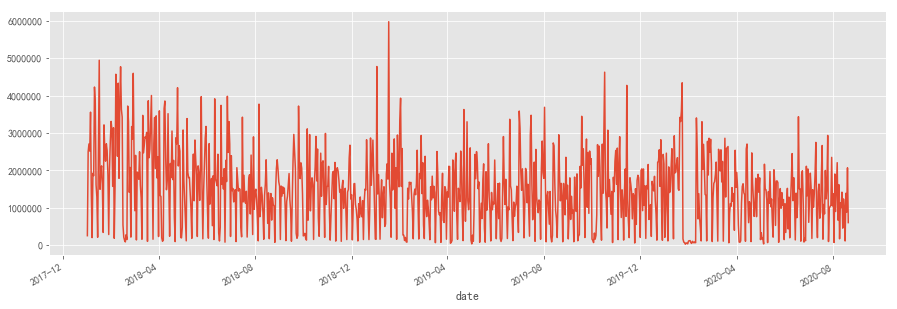

In [12]:
plt.style.use('ggplot')
fig = plt.subplots(figsize=(15,5))
daily_in_seq = sum_by_date(seq_filter_in(tmp_df_in, 500000))['txn_amt']
daily_in_seq.plot()
# sum_by_date(tmp_df_in)

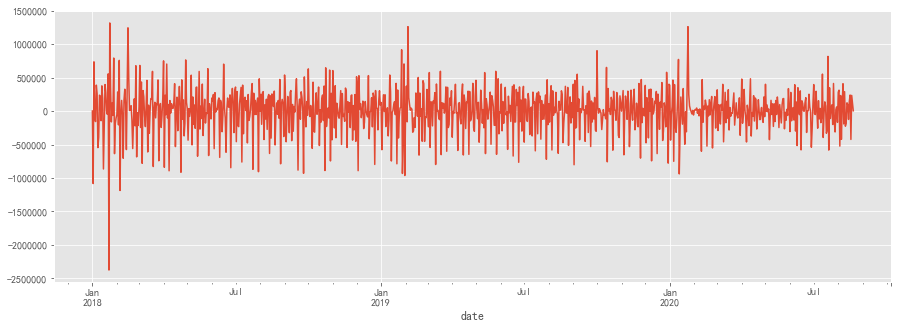

In [13]:

fig = plt.subplots(figsize=(15,5))
daily_out_seq = sum_by_date(seq_filter_out(tmp_df_out, -50000))['txn_amt']
daily_out_seq.diff(1).fillna(0).plot()
# sum_by_date(tmp_df_in)

In [14]:
res = sm.tsa.adfuller(daily_in_seq, regression='ct')
print('in_seq:',res[1])
res = sm.tsa.adfuller(daily_out_seq, regression='ct')
print('out_seq:',res[1])

in_seq: 1.86391085778e-05
out_seq: 1.24654364525e-05


In [15]:
res = sm.tsa.adfuller(daily_in_seq.diff().fillna(0), regression='c')
print('in_seq_diff',res[1])
res = sm.tsa.adfuller(daily_out_seq.diff().fillna(0), regression='c')
print('out_seq_diff',res[1])

in_seq_diff 1.10795194979e-20
out_seq_diff 5.12554528529e-17


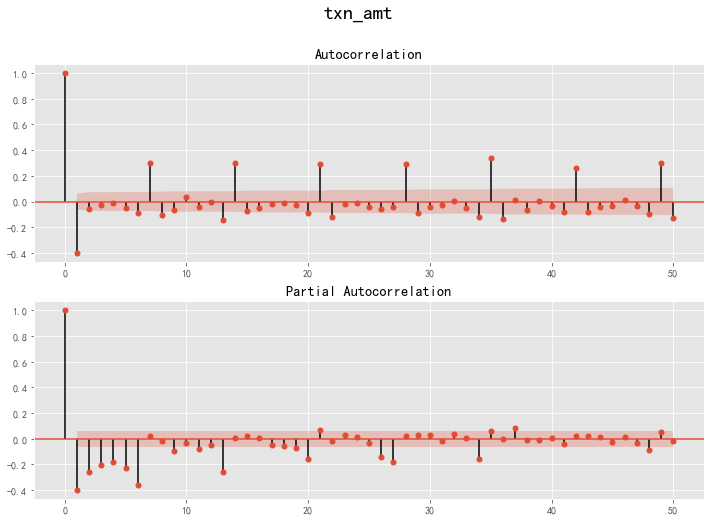

In [16]:
autocorrelation(daily_in_seq.diff().fillna(0), 50)

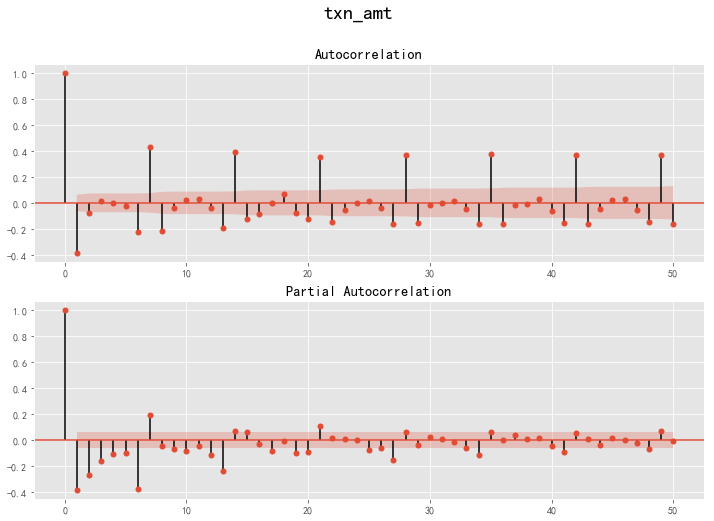

In [17]:
autocorrelation(daily_out_seq.diff().fillna(0), 50)

In [18]:
start = time.time()
order_evaluate = sm.tsa.arma_order_select_ic(daily_out_seq,ic='aic', trend='c', max_ar=7, max_ma=7)
print('ARMA(p,q) =',order_evaluate['aic_min_order'],'is the best.')
end = time.time()
print(end-start)

C:\Users\62449\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:628: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\62449\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:628: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\62449\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:629: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\62449\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:629: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\62449\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:584: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
C:\Users\62449\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:585: RuntimeWarning: overfl

ARMA(p,q) = (7, 7) is the best.
91.32932615280151


C:\Users\62449\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [44]:
start = time.time()
order_evaluate = sm.tsa.arma_order_select_ic(daily_out_seq.diff().fillna(0),ic='aic', trend='c', max_ar=7, max_ma=7)
print('ARMA(p,q) =',order_evaluate['aic_min_order'],'is the best.')
end = time.time()
print(end-start)

C:\Users\TerryCai\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\TerryCai\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\TerryCai\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\TerryCai\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\TerryCai\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Te

ARMA(p,q) = (6, 7) is the best.
422.5582203865051


C:\Users\TerryCai\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [23]:
start= time.time()
arima = sm.tsa.statespace.SARIMAX(daily_out_seq[:'20200531'], order=(7,0,7), seasonal_order=(0,0,0,0),
                                 enforce_stationarity=False, enforce_invertibility=False).fit()
arima.summary()
print(time.time()-start)

C:\Users\62449\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


8.079395771026611


ARIMA model RMSE:260722.75754157605
ARIMA model MAE:203701.8864232915
ARIMA model MAPE:50.34253071660314


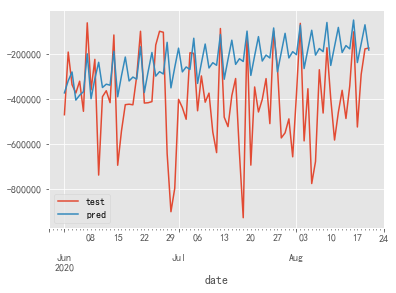

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
pred = arima.predict(start='20200531',end='20200820')[1:]
print('ARIMA model RMSE:{}'.format(np.sqrt(mean_squared_error(daily_out_seq['20200601':'20200820'],pred))))
print('ARIMA model MAE:{}'.format(mean_absolute_error(daily_out_seq['20200601':'20200820'],pred)))
print('ARIMA model MAPE:{}'.format(mape(daily_out_seq['20200601':'20200820'],pred)))
pd.DataFrame({'test':daily_out_seq['20200601':'20200820'],'pred':pred}).plot()
plt.show()

In [ ]:
start= time.time()
arima = sm.tsa.statespace.SARIMAX(daily_out_seq[:'20200531'], order=(7,0,7), freq='D', seasonal_order=(7,1,7,1),
                                 enforce_stationarity=False, enforce_invertibility=False).fit()
arima.summary()
print(time.time()-start)

ARIMA model RMSE:180968.01368219103
ARIMA model MAE:139575.60217127574
ARIMA model MAPE:55.81431043041398


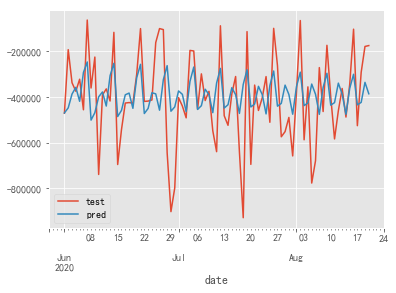

In [29]:
from sklearn.metrics import mean_squared_error
pred = arima.predict(start='20200531',end='20200820')[1:]
print('ARIMA model RMSE:{}'.format(np.sqrt(mean_squared_error(daily_out_seq['20200601':'20200820'],pred))))
print('ARIMA model MAE:{}'.format(mean_absolute_error(daily_out_seq['20200601':'20200820'],pred)))
print('ARIMA model MAPE:{}'.format(mape(daily_out_seq['20200601':'20200820'],pred)))
pd.DataFrame({'test':daily_out_seq['20200601':'20200820'],'pred':pred}).plot()
plt.show()